# Hands-on: Numerical Python -- Getting Real -- Let's reproduce Haxby 2001

Do you remember `tutorial_data` we have fetched and used for some excercises?  It is a single subject from [Haxby et al 2001](http://www.sciencemag.org/content/293/5539/2425.long) paper.  Today we will try to reproduce (at least partially) the analysis and results reported in the paper, in particular:

![haxby2001_fig4](http://www.sciencemag.org/content/293/5539/2425/F4.large.jpg)

We will though analyze two different masks, instead of looking at *all* vs *maximal responsive* voxels: eov (early visual cortex) and vt (ventra temporal cortex).

All necessary data is available from `tutorial_data` we have fetched earlier using git-annex:  `tutorial_data/data/attributes.txt` provides us labels for each of the TRs and run index.

In [6]:
!pwd

/Users/feilong/git/psyc161/classes


In [4]:
!git clone http://data.pymvpa.org/datasets/tutorial_data/.git

Cloning into 'tutorial_data'...
Checking connectivity... done.


In [12]:
!ls -a tutorial_data/haxby2001

.                 bold_mc.par       mask_vt.nii.gz    sub001
..                bold_mean.nii.gz  mask_white.nii.gz task_key.txt
anat.nii.gz       mask_brain.nii.gz models
attributes.txt    mask_gray.nii.gz  scan_key.txt
bold.nii.gz       mask_hoc.nii.gz   study_key.txt


In [36]:
!ln -s haxby2001/ tutorial_data/data

In [44]:
!cd tutorial_data/data; git annex get anat.nii.gz mask_* bold.nii.gz

(merging origin/git-annex into git-annex...)
(recording state in git...)
/var/folders/d8/7fv 100%[=====================>]     316  --.-KB/s   in 0s     
../.git/annex/tmp/S 100%[=====================>] 147.77K   181KB/s   in 0.8s   
ok
../.git/annex/tmp/S 100%[=====================>]   6.84K  --.-KB/s   in 0.04s  
ok
../.git/annex/tmp/S 100%[=====================>]  17.33K  --.-KB/s   in 0.09s  
ok
../.git/annex/tmp/S 100%[=====================>]   6.03K  --.-KB/s   in 0.03s  
ok
../.git/annex/tmp/S 100%[=====================>]   3.91K  --.-KB/s   in 0s     
ok
../.git/annex/tmp/S 100%[=====================>]  14.78K  --.-KB/s   in 0.07s  
ok
../.git/annex/tmp/S 100%[=====================>] 294.28M  3.25MB/s   in 1m 41s 
ok
(recording state in git...)


In [38]:
!head tutorial_data/data/attributes.txt 

rest 0
rest 0
rest 0
rest 0
rest 0
rest 0
scissors 0
scissors 0
scissors 0
scissors 0


In [67]:
import numpy as np
import nibabel as nib
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
# Read the stimulus data file from attributes.txt, and obtain two numpy arrays/vectors:
mat = np.loadtxt('tutorial_data/data/attributes.txt', dtype=str)
targets = mat[:,0]
chunks = mat[:,1].astype(int)

We will need to load the same BOLD and masks for early visual and ventra-temporal corteces.

In [50]:
# Load BOLD data per each ROI into a dictionary containing data arrays per each mask
ROIs = ('vt', 'hoc')
all_data = {}
bold = nib.load('tutorial_data/data/bold.nii.gz').get_data()
for roi in ROIs:
    mask = nib.load('tutorial_data/data/mask_%s.nii.gz' % roi).get_data()
    if roi == 'hoc':
        all_data[roi] = bold[mask==48]
    else:
        all_data[roi] = bold[mask>0]
# all_data = {...}

In [51]:
print bold.shape
for roi in ROIs:
    print roi, all_data[roi].shape

(40, 64, 64, 1452)
vt (577, 1452)
hoc (594, 1452)


But meanwhile let's start working with a single ROI, e.g. 'vt'

In [52]:
data = all_data['vt']

Using `chunks` array we have loaded, first split `data` (and `stimuli`) into even and odd runs

In [55]:
print data.shape

(577, 1452)


In [85]:
even = stats.zscore(data[:, chunks%2 == 0], axis=1)
even_targets = targets[chunks%2 == 0]
odd = stats.zscore(data[:, chunks%2 == 1], axis=1)
odd_targets = targets[chunks%2 == 1]
print even.shape, odd.shape, data.shape

(577, 726) (577, 726) (577, 1452)


Now per each of the two splits, estimate mean response pattern per each category (among `stimuli`)

In [93]:
UT = ['face', 'house', 'cat', 'bottle', 'scissors', 'shoe', 'chair', 'scrambledpix']

In [86]:
means = {'even':{}, 'odd':{}}
for half in ['even', 'odd']:
    d = eval(half)
    half_targets = eval('%s_targets'%half)
    for target in UT:
        means[half][target] = d[:, half_targets==target].mean(axis=1)

In [87]:
stats.pearsonr(means['even']['face'], means['odd']['cat'])

(0.24483556017393196, 2.5327035088816128e-09)

In [74]:
print means['even']['bottle'].shape

(577,)


Compute correlations between those patterns across splits/targets

In [94]:
mat = np.ones((8, 8))
for i, t1 in enumerate(UT):
    for j, t2 in enumerate(UT):
        mat[i, j] = stats.pearsonr(means['even'][t1], means['odd'][t2])[0]

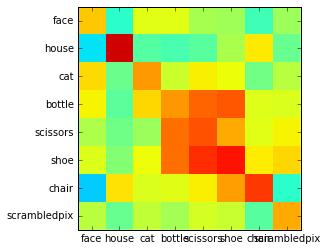

In [96]:
plt.imshow(mat, interpolation='none', vmax=1, vmin=-1)
plt.xticks(range(len(UT)), UT)
plt.yticks(range(len(UT)), UT)
plt.show()

Visualize them using similar to the publication -- no error bars, nor fancy images, but category labels (`targets`) should be there

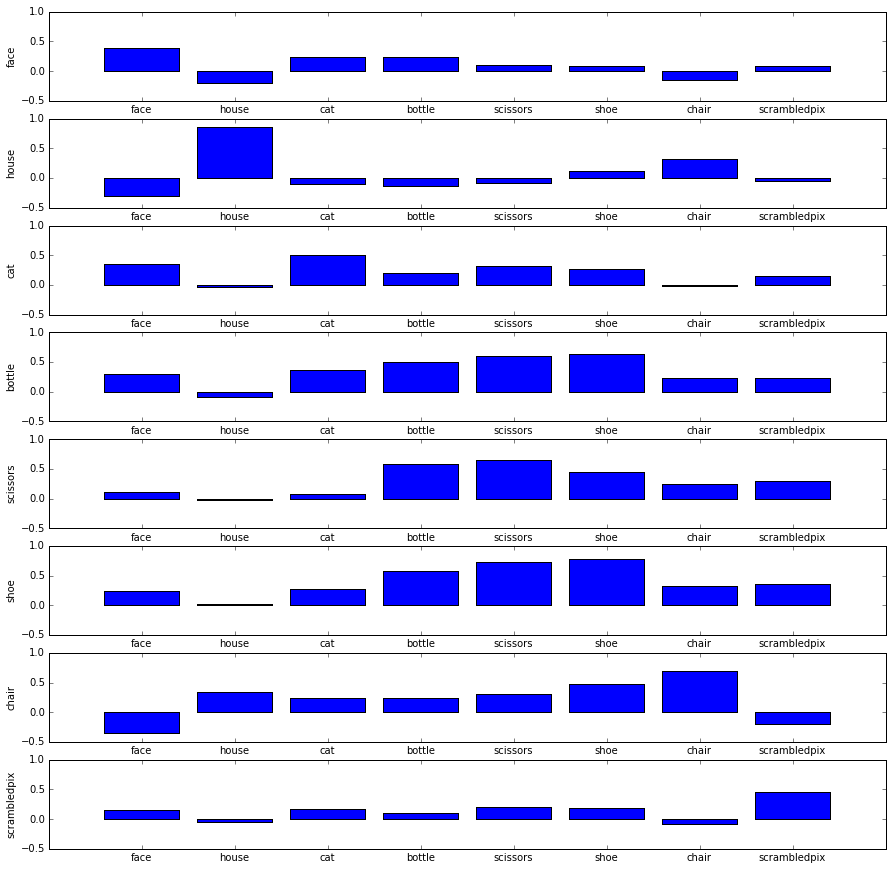

In [104]:
fig, subs = plt.subplots(8, 1, figsize=(15,15))
for i, t1 in enumerate(UT):
    subs[i].bar([_ - .4 for _ in range(len(UT))], mat[i,:])
    subs[i].set_ylim([-.5, 1])
    subs[i].set_xticks(range(len(UT)))
    subs[i].set_xticklabels(UT)
    subs[i].set_yticks([-.5, 0, .5, 1])
    subs[i].set_ylabel(t1)
plt.show()

## Code refactoring

Now we have all functionality, given some data and a design, to obtain correlation between different categories across splits of data.  In the next cell, let's create a function which would incorporate the code we have developed above:

In [ ]:
def haxby2001_analysis(data, stimuli):
    # TODO
    return correlations

which we could now apply to the data for multiple ROIs we have previously loaded into `all_data`:

but before jumping to visualize the results, given our respect to testing, what kind of unit-tests could we create?

In [ ]:
from nose.testing import assert_equal
from numpy.testing import assert_array_equal

def test_haxby2001_TODO():
    # TEST IT
    pass

test_haxby2001_TODO()

and after we got confidence that things are working as the should, we could generate our fancy ultimate figure demostrating our results with barplots:
similarly to the original figure make them of different colors for within/between categories and two different ROIs we have:

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.bar

## Extra for hungry minds

Fetch all of the haxby2001 study data, reuse above code/function to process all the subjects and adjust your ultimate plot with mean and stderr bars across subjects:

In [ ]:
!git clone http://data.pymvpa.org/datasets/haxby2001/.git

In [ ]:
!cd haxby2001; git annex get */bold.nii.gz */labels.txt */mask*